In [10]:
import os
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point
pd.set_option('display.max_columns', None)
os.listdir('./data/')

['.gitattributes',
 'Accidents0515.csv',
 'london_poly.json',
 'london_roads.json',
 'preprocessed',
 'Road Safety Data - Accidents 2019.csv']

In [11]:
def preprocessing_total(df):
    # drop na
    df['LSOA_of_Accident_Location'].fillna('unknown', inplace=True)
    df.dropna(axis=0, inplace=True)

    # drom features which we will not know in the new data
    columns_to_drop = [
        'Accident_Index',
        'Accident_Severity',
        'Did_Police_Officer_Attend_Scene_of_Accident',
        'Number_of_Casualties',
        'Number_of_Vehicles',
        'Police_Force',
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    
    # drop not London points
    df['datetime'] = pd.to_datetime(df['Date'] + '/' + df['Time'])
    df['geom'] = df.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
    df['in_london'] = df['geom'].apply(lambda x: x.intersects(london_poly))
    return df

In [12]:
def preprocessing_london(df):
    df_filtered = df[df['in_london']].drop(columns=['in_london', 'Date', 'Time'])
    df_filtered_numeric = df_filtered.drop(columns=['Local_Authority_(Highway)', 'LSOA_of_Accident_Location', 
                                                    'geom', 'datetime'])
    df_filtered_numeric['month'] = df['Date'].apply(lambda x: int(x.split('/')[1]))
    df_filtered_numeric['hour'] = df['Time'].apply(lambda x: int(x.split(':')[0]))
    return df_filtered_numeric

In [13]:
accidents = pd.read_csv('./data/Accidents0515.csv')

In [14]:
# there is one column with many nan values
# since we do not know if this columns useful or not --> fill na with 'unknown' string
accidents.isna().sum(axis=0)

Accident_Index                                      0
Location_Easting_OSGR                             138
Location_Northing_OSGR                            138
Longitude                                         138
Latitude                                          138
Police_Force                                        0
Accident_Severity                                   0
Number_of_Vehicles                                  0
Number_of_Casualties                                0
Date                                                0
Day_of_Week                                         0
Time                                              151
Local_Authority_(District)                          0
Local_Authority_(Highway)                           0
1st_Road_Class                                      0
1st_Road_Number                                     0
Road_Type                                           0
Speed_limit                                         0
Junction_Detail             

In [15]:
with open('./data/london_poly.json') as json_fin:
    js_line = json_fin.read()
london_gdf = gpd.read_file(json.loads(js_line))
london_poly = london_gdf['geometry'][0]

In [16]:
accidents = preprocessing_total(accidents)

In [17]:
accidents_filtered_numeric = preprocessing_london(accidents)

In [18]:
from sklearn.ensemble import IsolationForest

In [19]:
forest = IsolationForest(n_jobs=-1, random_state=42)

In [20]:
forest.fit(accidents_filtered_numeric)

IsolationForest(n_jobs=-1, random_state=42)

In [21]:
accidents_filtered_numeric['outliers_score'] = forest.decision_function(accidents_filtered_numeric)

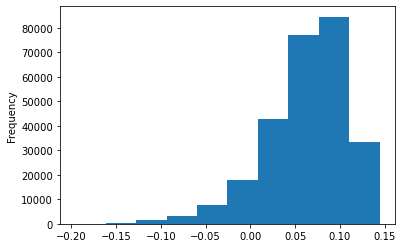

In [14]:
accidents_filtered_numeric['outliers_score'].plot(kind='hist')

In [15]:
accidents_test = pd.read_csv('./data/Road Safety Data - Accidents 2019.csv')

C:\Users\asi30\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
accidents_test = preprocessing_total(accidents_test)
accidents_test_numeric = preprocessing_london(accidents_test)

In [20]:
accidents_test_numeric.columns

Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Day_of_Week', 'Local_Authority_(District)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'month', 'hour', 'outliers_score'],
      dtype='object')

In [23]:
accidents_test_numeric['outliers_score'] = forest.decision_function(accidents_test_numeric.drop(columns=['outliers_score']))

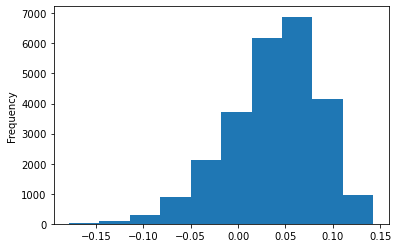

In [24]:
accidents_test_numeric['outliers_score'].plot(kind='hist')

In [ ]:
# def get_lat_lon_mult():
#     return (1.001 - 0.999) * np.random.random_sample() + 0.999 # about 100 meters shift

In [ ]:
# for row in accidents_filtered.iterrows():
#     for _ in range(3):
#         new_lat = row['Latitude'] * get_lat_lon_mult()
#         new_lon = row['Lon'] * get_lat_lon_mult()

In [22]:
accidents_filtered_numeric.to_pickle('./data/preprocessed/accidents_with_score.pkl')